<a href="https://colab.research.google.com/github/19521242bao/CS116/blob/main/FinalProject/CS116_SVM_Multi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p align="center">
  <a href="https://www.uit.edu.vn/" title="Trường Đại học Công nghệ Thông tin" style="border: none;">
    <img src="https://i.imgur.com/WmMnSRt.png" alt="Trường Đại học Công nghệ Thông tin | University of Information Technology">
  </a>
</p>

<h3 align="center"><b>CS116.M12.KHCL - Machine Learning with Python</b></h3>
<h2 align="center"><b>ĐỒ ÁN CUỐI KỲ</b></h2>
<h1 align="center"><b>SUPPORT VECTOR MACHINE</b></h1>

**Dataset: Glass Identification**

**Sinh viên thực hiện:** 

<ul>
  <li>Lương Phạm Bảo - 19521242</li>
  <li>Nguyễn Gia Thống - 19520993</li>
  <li>Phạm Ngọc Dương - 19521412</li>
</ul>

# Import các thư viện cần thiết

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Data preprocessing

## Load data

In [ ]:
!gdown --id 1v2XExGtLbjcgZ6TNfCG-ztG3fAEDsF5Q

Downloading...
From: https://drive.google.com/uc?id=1v2XExGtLbjcgZ6TNfCG-ztG3fAEDsF5Q
To: /content/glass.csv
100% 10.1k/10.1k [00:00<00:00, 15.7MB/s]


In [ ]:
df = pd.read_csv('/content/glass.csv')
features = df.columns[:-1].tolist()
df.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [ ]:
df.shape

(214, 10)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      214 non-null    float64
 1   Na      214 non-null    float64
 2   Mg      214 non-null    float64
 3   Al      214 non-null    float64
 4   Si      214 non-null    float64
 5   K       214 non-null    float64
 6   Ca      214 non-null    float64
 7   Ba      214 non-null    float64
 8   Fe      214 non-null    float64
 9   Type    214 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 16.8 KB


## View datadata

In [ ]:
df.describe()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009,2.780374
std,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439,2.103739
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,1.516523,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000,1.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000,2.000000
75%,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000,3.000000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,7.000000


2    76
1    70
7    29
3    17
5    13
6     9
Name: Type, dtype: int64


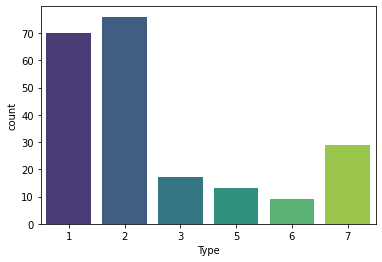

In [ ]:
df['Type'].value_counts() * 100 / len(df)
sns.countplot(x='Type', data=df, palette='viridis')
print(df['Type'].value_counts())

## Visualize data

### Visualize correlation between the features

<Figure size 576x576 with 0 Axes>

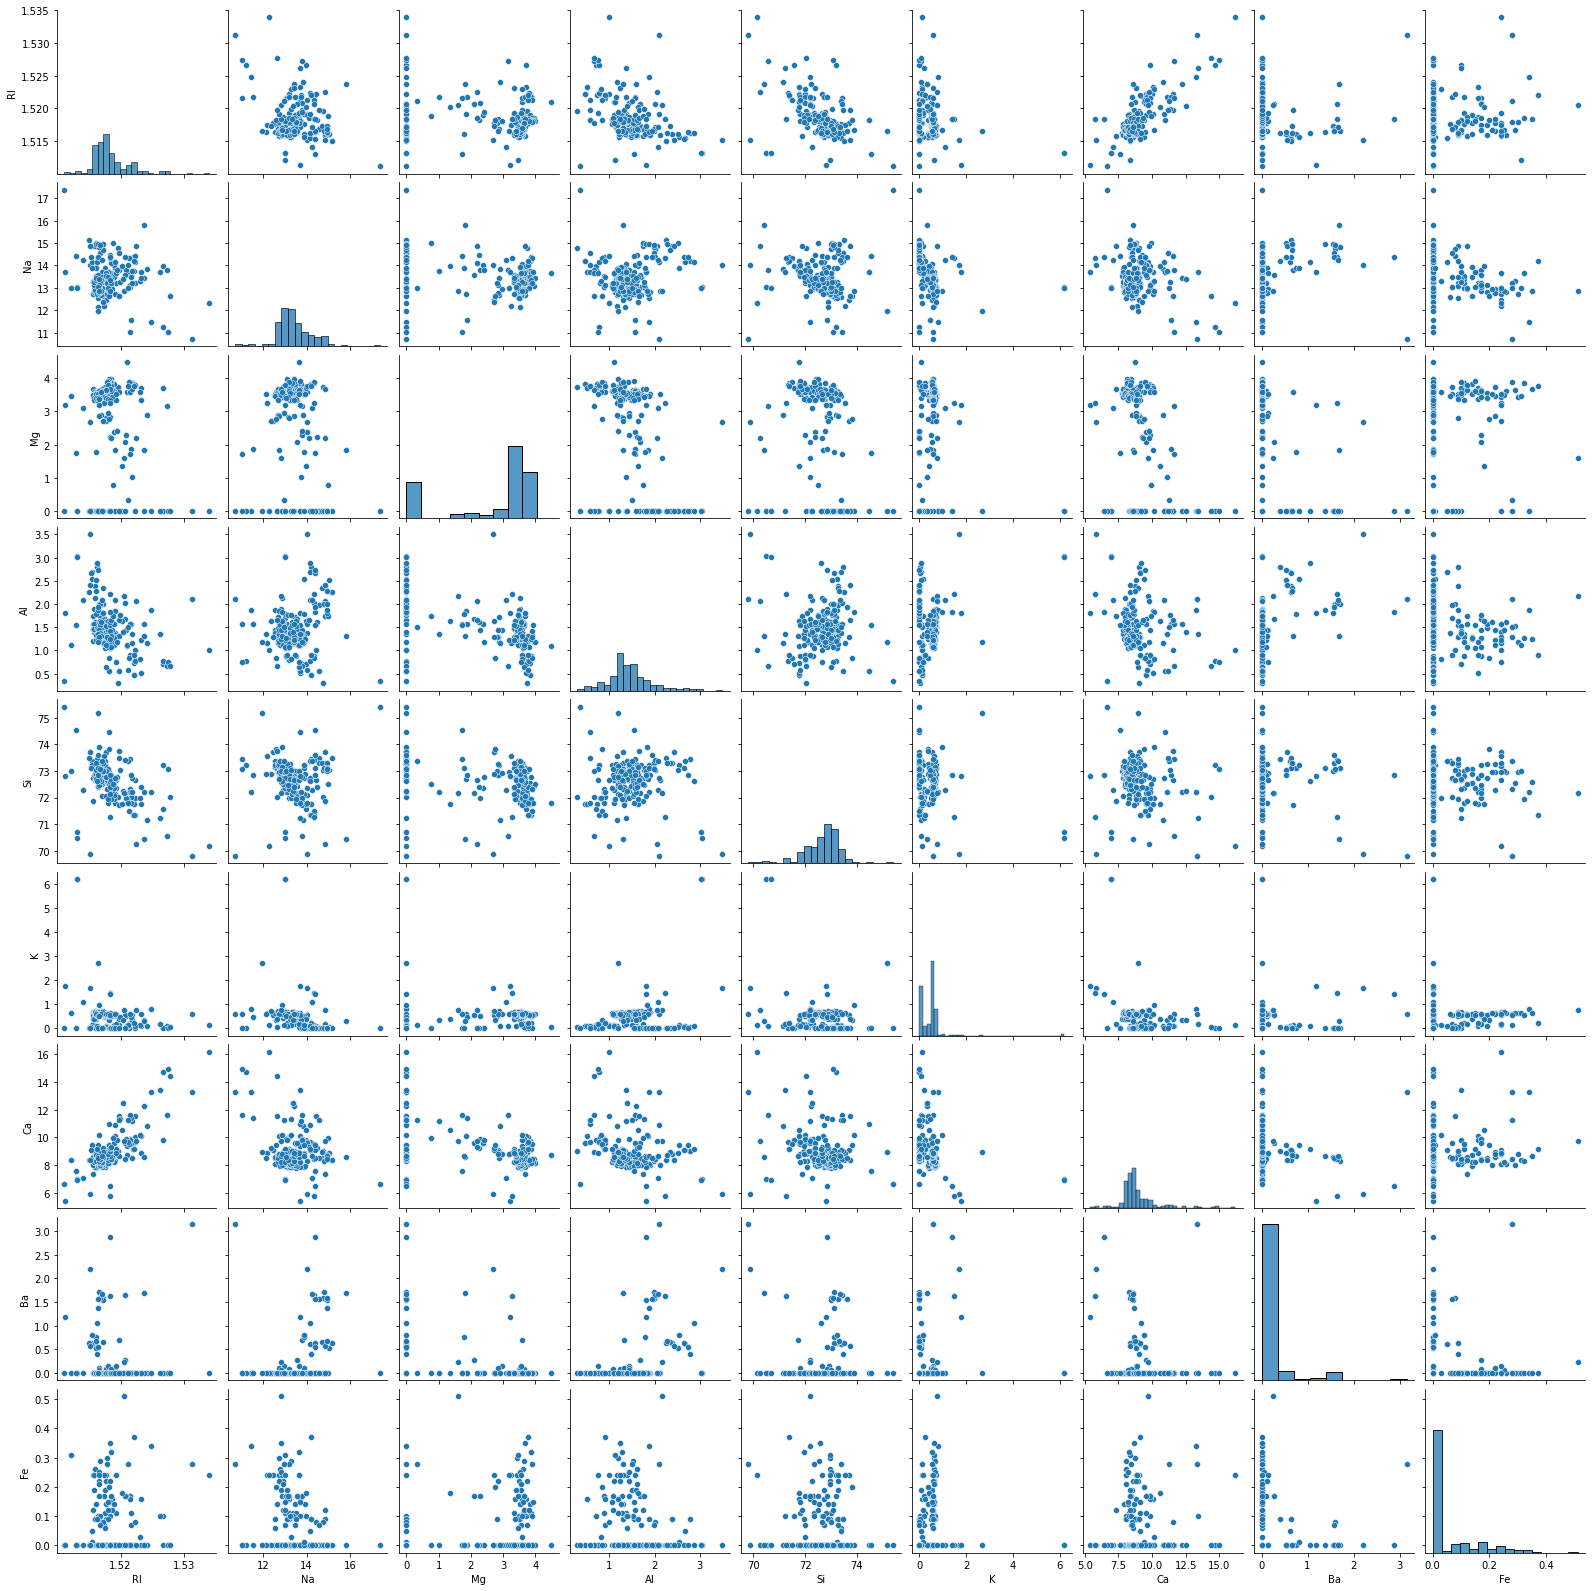

In [ ]:
plt.figure(figsize=(8,8))
sns.pairplot(df[features],palette='coolwarm')
plt.show()

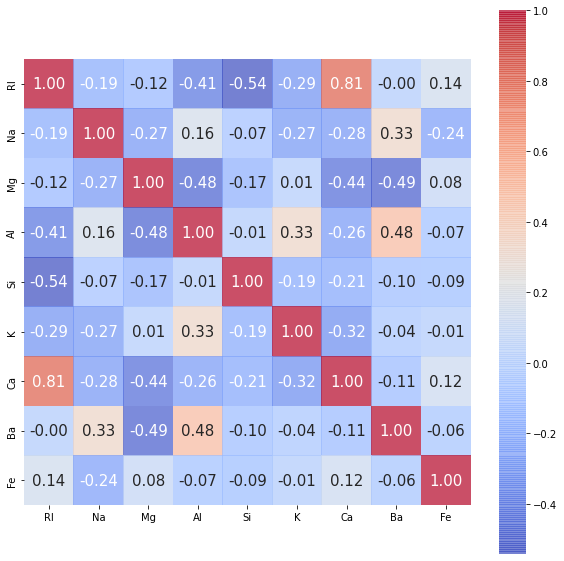

In [ ]:
corr = df[features].corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           xticklabels= features, yticklabels= features, alpha = 0.7,   cmap= 'coolwarm')
plt.show()

### Detect & Eliminate outlier

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  after removing the cwd from sys.path.


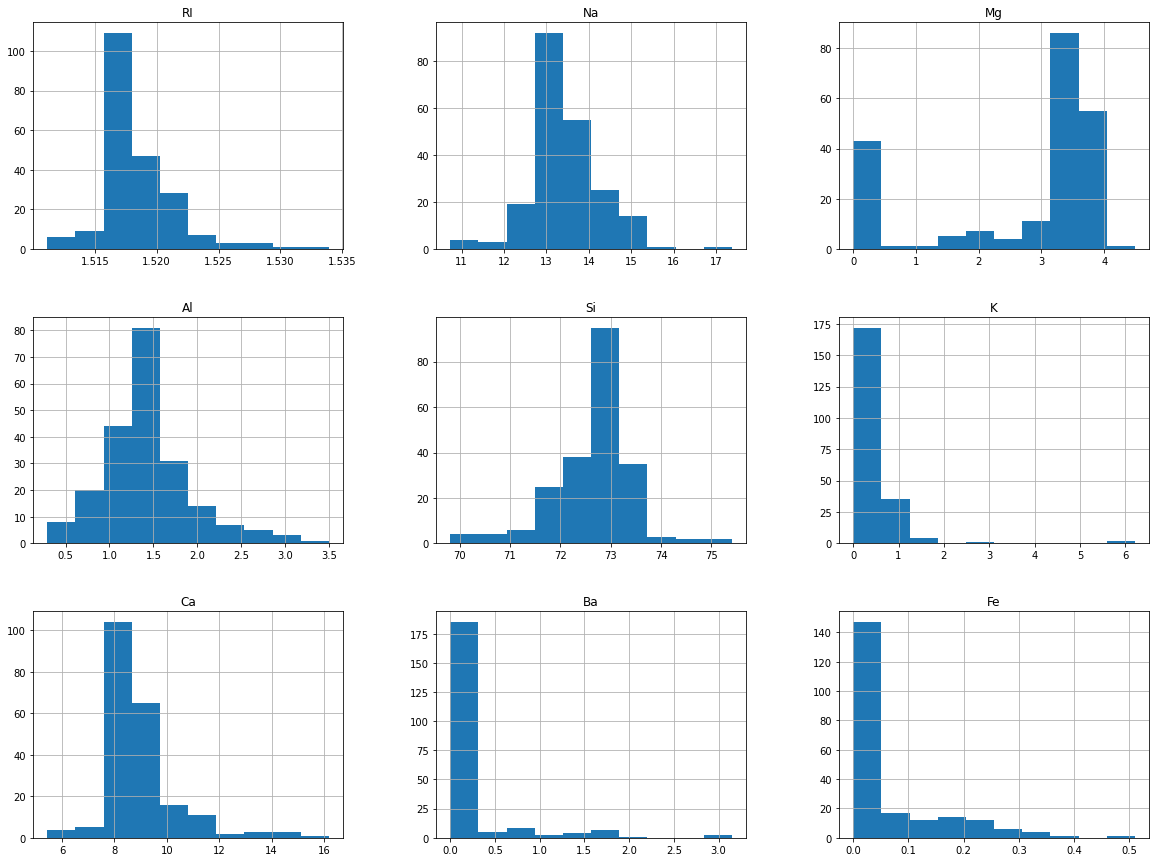

In [ ]:
feature_df = df.iloc[:, 0:9]
fig = plt.figure(figsize = (20,15))
ax = fig.gca()
feature_df.hist(ax=ax)
plt.show()

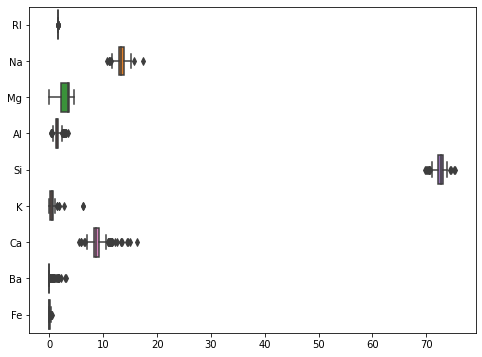

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=feature_df, orient="h")

In [ ]:
# Detect observations with more than one outlier

def outlier_hunt(df):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than 2 outliers. 
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in df.columns.tolist():
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        
        # Interquartile rrange (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > 2 )
    
    return multiple_outliers   

print('The dataset contains %d observations with more than 2 outliers' %(len(outlier_hunt(df[features]))))

The dataset contains 14 observations with more than 2 outliers


In [ ]:
# Eliminate outlier in dataset
outlier_indices = outlier_hunt(df[features])
df = df.drop(outlier_indices).reset_index(drop=True)
print(df.shape)

(200, 10)


## Chuẩn bị data với format model sử dụngdụng

In [ ]:
X = df[features]
y = df['Type']

In [ ]:
X.shape

(200, 9)

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2
X=SelectKBest(chi2,k=8).fit_transform(X,y)


Split training test & testing set

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# from sklearn.preprocessing import StandardScaler
# # Standardizing our training and testing data.

# scaler = StandardScaler()
# X_train= scaler.fit_transform(X_train)
# X_test=scaler.transform(X_test)

Normalize data using Min-Max Normalization

In [ ]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Train model

In [ ]:
modelsvm = svm.SVC()
modelsvm.fit(X_train, y_train)
print("Accuracy on training set: ",modelsvm.score(X_train, y_train))
print("Accuracy on testing set: ",modelsvm.score(X_test, y_test))
y_pred = modelsvm.predict(X_test)
print(classification_report(y_test, y_pred))

Accuracy on training set:  0.85
Accuracy on testing set:  0.575
              precision    recall  f1-score   support

           1       0.57      0.57      0.57        14
           2       0.59      0.67      0.62        15
           3       0.00      0.00      0.00         3
           5       0.67      0.67      0.67         3
           6       1.00      0.50      0.67         2
           7       1.00      0.67      0.80         3

    accuracy                           0.57        40
   macro avg       0.64      0.51      0.55        40
weighted avg       0.60      0.57      0.58        40



# So sánh các model

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

In [ ]:
def TrainModel(model, model_name):
    model.fit(X_train, y_train)
    print(model_name + ":\t",model.score(X_test, y_test))
    y_pred=model.predict(X_test)
    score_f1=f1_score(y_test,y_pred,average='micro')
    print(model_name + ":\t",score_f1)


In [ ]:
model1 = KNeighborsClassifier(n_neighbors=5)
TrainModel(model1, model_name="K Nearest Neighbor")

model2 = svm.SVC()
TrainModel(model2, model_name="Support Vector Machine (Linear Classifier)")

model3 = svm.SVC(kernel='rbf')
TrainModel(model3, model_name="Support Vector Machine (RBF Classifier)")

model4 = GaussianNB()
TrainModel(model4, model_name="Gaussian Naive Bayes")

model5 = tree.DecisionTreeClassifier()
TrainModel(model5, model_name="Decision Tree Classifier")

model6 = RandomForestClassifier(n_estimators=100)
TrainModel(model6, model_name="Random Forest Classifier")

model7 = XGBClassifier(random_state=1, eta=0.01)
TrainModel(model7, model_name="Xgboost Classifier")

model8 = GradientBoostingClassifier(learning_rate=0.01,random_state=1)
TrainModel(model8, model_name="GradientBoosting Classifier")

K Nearest Neighbor:	 0.6833333333333333
K Nearest Neighbor:	 0.6833333333333333
Support Vector Machine (Linear Classifier):	 0.6666666666666666
Support Vector Machine (Linear Classifier):	 0.6666666666666666
Support Vector Machine (RBF Classifier):	 0.6666666666666666
Support Vector Machine (RBF Classifier):	 0.6666666666666666
Gaussian Naive Bayes:	 0.5666666666666667
Gaussian Naive Bayes:	 0.5666666666666667
Decision Tree Classifier:	 0.6666666666666666
Decision Tree Classifier:	 0.6666666666666666
Random Forest Classifier:	 0.7666666666666667
Random Forest Classifier:	 0.7666666666666667
Xgboost Classifier:	 0.7666666666666667
Xgboost Classifier:	 0.7666666666666667
GradientBoosting Classifier:	 0.6666666666666666
GradientBoosting Classifier:	 0.6666666666666666


In [ ]:
model1 = KNeighborsClassifier(n_neighbors=5)
TrainModel(model1, model_name="K Nearest Neighbor")

model2 = svm.SVC()
TrainModel(model2, model_name="Support Vector Machine (Linear Classifier)")

model3 = svm.SVC(kernel='rbf')
TrainModel(model3, model_name="Support Vector Machine (RBF Classifier)")

model4 = GaussianNB()
TrainModel(model4, model_name="Gaussian Naive Bayes")

model5 = tree.DecisionTreeClassifier()
TrainModel(model5, model_name="Decision Tree Classifier")

model6 = RandomForestClassifier(n_estimators=100)
TrainModel(model6, model_name="Random Forest Classifier")

model7 = XGBClassifier(random_state=1, eta=0.01)
TrainModel(model7, model_name="Xgboost Classifier")

model8 = GradientBoostingClassifier(learning_rate=0.01,random_state=1)
TrainModel(model8, model_name="GradientBoosting Classifier")

K Nearest Neighbor:	 0.625
K Nearest Neighbor:	 0.625
Support Vector Machine (Linear Classifier):	 0.625
Support Vector Machine (Linear Classifier):	 0.625
Support Vector Machine (RBF Classifier):	 0.625
Support Vector Machine (RBF Classifier):	 0.625
Gaussian Naive Bayes:	 0.55
Gaussian Naive Bayes:	 0.55
Decision Tree Classifier:	 0.575
Decision Tree Classifier:	 0.575
Random Forest Classifier:	 0.725
Random Forest Classifier:	 0.7250000000000001
Xgboost Classifier:	 0.65
Xgboost Classifier:	 0.65
GradientBoosting Classifier:	 0.7
GradientBoosting Classifier:	 0.7


# Tuning Hyperparameter 

In [ ]:
# sử dụng gridSearch
from sklearn.model_selection import GridSearchCV
 
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['linear','rbf',"sigmoid"]}
 
grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3)
# fitting the model for grid search
grid.fit(X_train, y_train)
# print best parameter after tuning
print(grid.best_params_)
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)
print(grid.best_score_)

Fitting 5 folds for each of 75 candidates, totalling 375 fits
[CV 1/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.571 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.536 total time=   0.0s
[CV 3/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.607 total time=   0.0s
[CV 4/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.536 total time=   0.0s
[CV 5/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.643 total time=   0.0s
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.393 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.357 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.357 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.357 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.357 total time=   0.0s
[CV 1/5] END ....C=0.1, gamma=1, kernel=sigmoid;, score=0.571 total time=   0.0s
[CV 2/5] END ....C=0.1, gamma=1, kernel=sigmoid

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


[CV 1/5] END .......C=1, gamma=1, kernel=linear;, score=0.571 total time=   0.0s
[CV 2/5] END .......C=1, gamma=1, kernel=linear;, score=0.607 total time=   0.0s
[CV 3/5] END .......C=1, gamma=1, kernel=linear;, score=0.714 total time=   0.0s
[CV 4/5] END .......C=1, gamma=1, kernel=linear;, score=0.607 total time=   0.0s
[CV 5/5] END .......C=1, gamma=1, kernel=linear;, score=0.571 total time=   0.0s
[CV 1/5] END ..........C=1, gamma=1, kernel=rbf;, score=0.500 total time=   0.0s
[CV 2/5] END ..........C=1, gamma=1, kernel=rbf;, score=0.679 total time=   0.0s
[CV 3/5] END ..........C=1, gamma=1, kernel=rbf;, score=0.643 total time=   0.0s
[CV 4/5] END ..........C=1, gamma=1, kernel=rbf;, score=0.714 total time=   0.0s
[CV 5/5] END ..........C=1, gamma=1, kernel=rbf;, score=0.679 total time=   0.0s
[CV 1/5] END ......C=1, gamma=1, kernel=sigmoid;, score=0.536 total time=   0.0s
[CV 2/5] END ......C=1, gamma=1, kernel=sigmoid;, score=0.429 total time=   0.0s
[CV 3/5] END ......C=1, gamm

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
# Sử dụng RandomSearch
model=svm.SVC()
# Create the random grid
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['linear','rbf',"sigmoid"]}
  # Sử dụng hàm RandomizedSearchCV của thư viện sklearn để điểu chỉnh siêu tham số
rand = RandomizedSearchCV(model,param_grid, scoring='accuracy',refit = True, verbose = 3,cv=5)
# Tiến hành đào tạo
rand.fit(X_train, y_train)
# In ra kết quả
print("The best parameters are %s with a score of %0.2f"
      % (rand.best_params_, rand.best_score_))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END .....C=1, gamma=0.0001, kernel=rbf;, score=0.375 total time=   0.0s
[CV 2/5] END .....C=1, gamma=0.0001, kernel=rbf;, score=0.375 total time=   0.0s
[CV 3/5] END .....C=1, gamma=0.0001, kernel=rbf;, score=0.375 total time=   0.0s
[CV 4/5] END .....C=1, gamma=0.0001, kernel=rbf;, score=0.344 total time=   0.0s
[CV 5/5] END .....C=1, gamma=0.0001, kernel=rbf;, score=0.375 total time=   0.0s
[CV 1/5] END ...C=1000, gamma=0.001, kernel=rbf;, score=0.469 total time=   0.0s
[CV 2/5] END ...C=1000, gamma=0.001, kernel=rbf;, score=0.688 total time=   0.0s
[CV 3/5] END ...C=1000, gamma=0.001, kernel=rbf;, score=0.531 total time=   0.0s
[CV 4/5] END ...C=1000, gamma=0.001, kernel=rbf;, score=0.562 total time=   0.0s
[CV 5/5] END ...C=1000, gamma=0.001, kernel=rbf;, score=0.719 total time=   0.0s
[CV 1/5] END C=1000, gamma=0.001, kernel=sigmoid;, score=0.438 total time=   0.0s
[CV 2/5] END C=1000, gamma=0.001, kernel=sigmoi

In [ ]:
!pip install sklearn-genetic-opt

In [ ]:
!pip install sklearn-deap

In [ ]:
# Sử dụng EA Search 
from evolutionary_search import EvolutionaryAlgorithmSearchCV
model = svm.SVC()
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['linear','rbf',"sigmoid"]}
evolved_estimator = EvolutionaryAlgorithmSearchCV(estimator=model,
                                   params=param_grid ,
                                   scoring="accuracy",
                                   cv=5,
                                   verbose=33,
                                   population_size=10,
                                   gene_mutation_prob=0.10,
                                   gene_crossover_prob=0.8,
                                   tournament_size=3,
                                   generations_number=10,
                                   n_jobs=1)
evolved_estimator.fit(X_train,y_train)

# In ra kết quả
print("The best parameters are %s with a score of %0.2f"
      % (evolved_estimator.best_params_, evolved_estimator.best_score_))

In [ ]:
'kernel': 'linear', 'gamma': 0.1, 'C': 1000

In [ ]:
model2 = svm.SVC(C=10,gamma=0.1,kernel="rbf")
TrainModel(model2, model_name="Support Vector Machine (Linear Classifier)")

In [ ]:
visualize=pd.read_csv("model_multiclass.csv")

In [ ]:
models=list(visualize["Model"])
ACC_score=list(visualize["ACC"])


In [ ]:
ACC_score

[67.5, 67.5, 67.5, 55.0, 57.5, 77.5, 67.5, 67.5, 73.125]

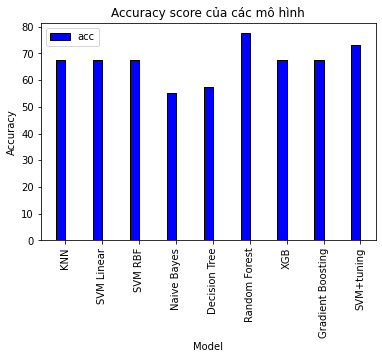

In [ ]:
n=len(models )
r = np.arange(n)
width = 0.25
  
  
plt.bar(r, ACC_score, color = 'b',
        width = width, edgecolor = 'black',label="acc")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Accuracy score của các mô hình")
  
# plt.grid(linestyle='--')
plt.xticks(r + width/2,models,rotation ='vertical')
plt.legend()
  
plt.show()